## Imports

In [40]:
pip install pyccel

In [41]:
import numpy as np
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D
from numba import njit

import time
from pyccel.epyccel import epyccel
from pyccel.decorators import types

## Pure python function

In [42]:
def solve_2d_linearconv_pure(u, un, nt, dt, dx, dy, c):
   
    row, col = u.shape

    for n in range(nt):  
        for i in range(row):
            for j in range(col):
                un[i][j] = u[i][j]
        for i in range(1, row): 
            for j in range(1,col):
                u[i][j] = un[i][j] - c * (dt / dx) * (un[i][j] - un[i-1][j]) - c * (dt / dy) * (un[i][j] - un[i][j-1]) 
    return 0

## Numba accelerator

In [43]:
@njit(fastmath=True)
def solve_2d_linearconv_numba(u, un, nt, dt, dx, dy, c):
   
    row, col = u.shape

    for n in range(nt):  
        for i in range(row):
            for j in range(col):
                un[i][j] = u[i][j]
        for i in range(1, row): 
            for j in range(1,col):
                u[i][j] = un[i][j] - c * (dt / dx) * (un[i][j] - un[i-1][j]) - c * (dt / dy) * (un[i][j] - un[i][j-1]) 
    return 0

## Pyccel accelerator

In [50]:
def solve_2d_linearconv_pyccel(u:'float[:,:]', un:'float[:,:]', nt:'int', dt:'float', dx:'float',dy:'float', c:'int'):
   
    row,col = u.shape

    for n in range(nt):  
        for i in range(row):
            for j in range(col):
                un[i][j] = u[i][j]
        for i in range(1, row): 
            for j in range(1,col):
                u[i][j] = un[i][j] - c * (dt / dx) * (un[i][j] - un[i-1][j]) - c * (dt / dy) * (un[i][j] - un[i][j-1]) 
    return 0


## Inputs

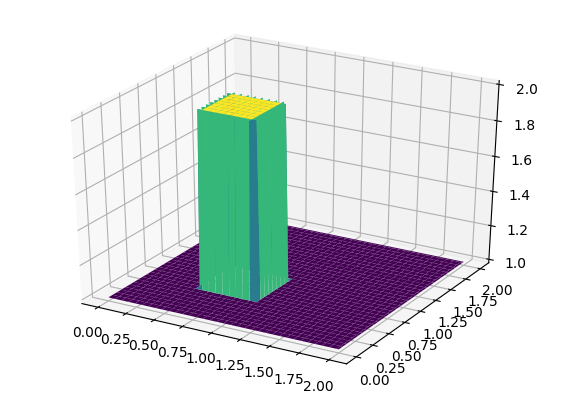

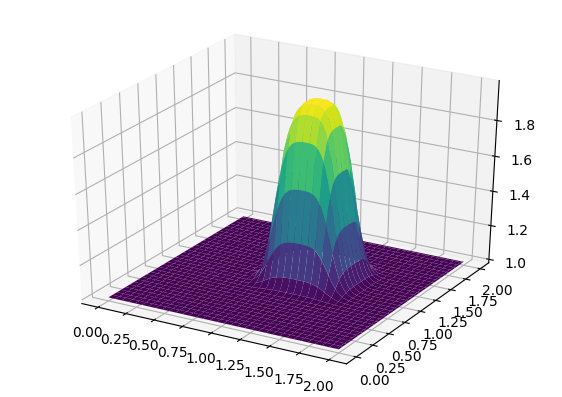

In [45]:
###variable declarations
nx = 101
ny = 101
nt = 100
c = 1
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
sigma = .2
dt = sigma * dx

x = np.linspace(0, 2, nx)
y = np.linspace(0, 2, ny)

u0 = np.ones((ny, nx)) ##create a 1xn vector of 1's
u0[int(.5 / dy):int(1 / dy + 1),int(.5 / dx):int(1 / dx + 1)] = 2 
u = u0.copy()
un = np.ones((ny, nx)) 

solve_2d_linearconv_pure(u, un, nt, dt, dx, dy, c)

fig = pyplot.figure(figsize=(7, 5), dpi=100)
ax = fig.gca(projection='3d')                      
X, Y = np.meshgrid(x, y)                            
surf = ax.plot_surface(X, Y, u0[:], cmap=cm.viridis)

fig = pyplot.figure(figsize=(7, 5), dpi=100)
ax = fig.gca(projection='3d')
surf2 = ax.plot_surface(X, Y, u[:], cmap=cm.viridis)

## Call Funtions

### Pure function

In [46]:
%timeit solve_2d_linearconv_pure(u, un, nt, dt, dx, dy, c)

1 loop, best of 5: 2.42 s per loop


### Function with numba accelerator

In [47]:
%timeit solve_2d_linearconv_numba(u, un, nt, dt, dx, dy, c)

The slowest run took 131.31 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 2.45 ms per loop


### Function with pyccel accelerator

In [51]:
solve_2d_linearconv_f90 = epyccel(solve_2d_linearconv_pyccel) 

In [52]:
%timeit solve_2d_linearconv_f90(u, un, nt, dt, dx, dy, c)

1000 loops, best of 5: 1.66 ms per loop
